In [1]:
from object_detection.utils import label_map_util, visualization_utils
import tensorflow as tf
import numpy as np
import os
%matplotlib inline

In [2]:
MODEL_PATH = '../tuned_model'
PATH_TO_SAVED_MODEL = MODEL_PATH + '/saved_model'

detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

2022-09-30 21:43:13.176081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 21:43:13.196116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 21:43:13.196756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 21:43:13.198594: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
image_path = '../test_images'

In [5]:
label_map_pbtxt_fname = '../config/label_map.pbxt'
category_index = label_map_util.create_category_index_from_labelmap(label_map_pbtxt_fname)

In [39]:
def predict_image(path):
    arr_image = np.array(Image.open(path))
    tensor_image = tf.convert_to_tensor(arr_image)
    tensor_image = tensor_image[tf.newaxis,...]
    detections = detect_fn(tensor_image)


    num_detections = int(detections.pop('num_detections'))
    detections = {key:value[0, :num_detections].numpy() 
                 for key, value in detections.items()
                 }

    detections['num_detections'] = num_detections

    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = arr_image.copy()

    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates = True,
        max_boxes_to_draw = 200,
        min_score_thresh = 0.1
    )
    plt.imshow(image_np_with_detections)
    plt.show()
    

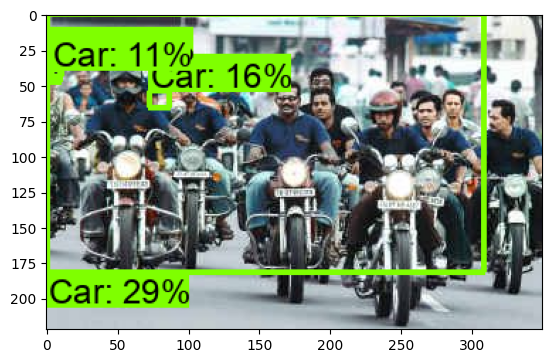

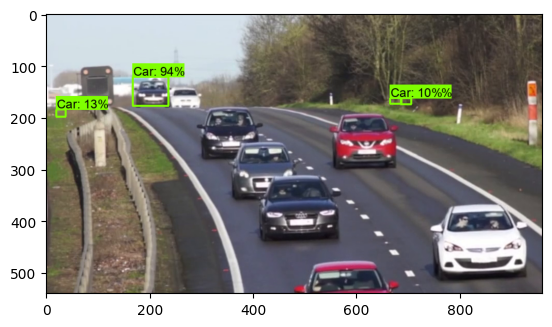

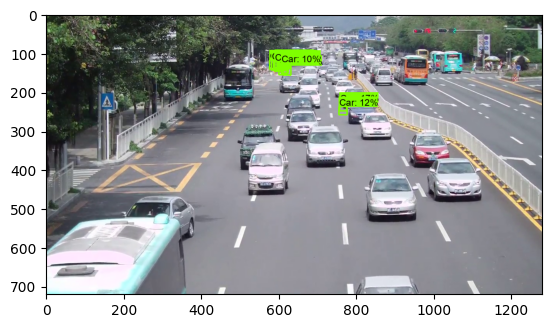

In [40]:
for image in os.listdir(image_path):
    predict_image(os.path.join(image_path,image))

In [31]:
import sys  
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path+"/src")

In [32]:
import numpy as np
import imutils
import time
import dlib
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from imutils.video import VideoStream
from imutils.video import FPS
from centroidtracker import CentroidTracker
from trackableobject import TrackableObject

In [33]:
PATH_VIDEO = '/media/nicolas/Lenovo/Projects/computer_vision_platzi/input/Videos_prueba/test_video.mp4'
PATH_VIDEO_OUT = '/media/nicolas/Lenovo/Projects/computer_vision_platzi/input/Videos_prueba/test_video_out.mp4'

In [34]:
SKIP_FPS = 30
THRESHOLD = 0.1

vs = cv2.VideoCapture(PATH_VIDEO)

writer = None

H = int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT))
W = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH))

In [35]:
ct = CentroidTracker(maxDisappeared=40, maxDistance=50)
trackers = [] 
trackableObjects = {}

In [36]:
totalFrame = 0
totalFown = 0
totalUp = 0
totalDown = 0
DIRECTION_PEOPLE = True


POINT = [0, int((H/2) - H*0.1), W, int(H*0.1)]

fps = FPS().start()

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
writer = cv2.VideoWriter(PATH_VIDEO_OUT, fourcc, 20.0, (W,H), True)

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [37]:
while True:
    ret, frame = vs.read()
    if frame is None:
        break
    status = 'waiting'
    rects = []
    if totalFrame % SKIP_FPS == 0:
        status = 'detecting'
        trackers = []
        
        arr_image = np.array(frame)
        tensor_image = tf.convert_to_tensor(arr_image)
        tensor_image = tensor_image[tf.newaxis,...]
        detections = detect_fn(tensor_image)
        detections_scores = np.array(detections['detection_scores'][0])
        
        detection_clean = [x for x in detections_scores if x > THRESHOLD]
        
        for x in range(len(detection_clean)):
            idx = int(detections['detection_classes'][0][x])
            
            ymin, xmin, ymax, xmax = np.array(detections['detection_boxes'][0][x])
            
            box = [xmin,ymin,xmax,ymax] * np.array([W,H,W,H])
            
            (startX, startY, endX, endY) = box.astype('int')
            tracker = dlib.correlation_tracker()
            rect = dlib.rectangle(startX, startY, endX, endY)
            tracker.start_track(frame,rect)
            trackers.append(tracker)
    else:
        for tracker in trackers:
            status = 'Tracking'
            tracker.update(frame)
            pos = tracker.get_position()
            startX = int(pos.left())
            startY = int(pos.top())
            endX = int(pos.right())
            endY = int(pos.bottom())
            rects.append((startX, startY, endX, endY))
            
    cv2.rectangle(frame, (POINT[0], POINT[1]),(POINT[0] + POINT[2], POINT[1] + POINT[3]),
                          (255,0 , 255),2)
    objects = ct.update(rects)
    
    for (objectID, centroid) in objects.items():
        # Revisamos si el objeto ya se ha contado
        to = trackableObjects.get(objectID, None)
        if to is None:
            to = TrackableObject(objectID, centroid)

        else:
          # if no count look at direction
            y = [c[1] for c in to.centroids]
            direction = centroid[1] - np.mean(y)
            to.centroids.append(centroid)
            if not to.counted:
                if centroid[0] > POINT[0] and centroid[0] < (POINT[0]+ POINT[2]) and centroid[1] > POINT[1] and centroid[1] < (POINT[1]+POINT[3]):
                    if DIRECTION_PEOPLE:
                        if direction >0:
                            totalUp += 1
                            to.counted = True
                        else:
                            totalDown +=1
                            to.counted = True
                    else:
                        if direction <0:
                            totalUp += 1
                            to.counted = True
                        else:
                            totalDown +=1
                            to.counted = True

        trackableObjects[objectID] = to

        # Draw centroid and id
        text = "ID {}".format(objectID)
        cv2.putText(frame, text, (centroid[0]-10, centroid[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
        cv2.circle(frame, (centroid[0], centroid[1]), 4, (0,255,0), -1)
  
     #total final results
    info = [
          ("Subiendo", totalUp),
          ("Bajando", totalDown),
          ("Estado", status),
    ]

    for (i, (k,v)) in enumerate(info):
        text = "{}: {}".format(k,v)
        cv2.putText(frame, text, (10, H - ((i*20) + 20)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

    # save frame in video
    writer.write(frame)
    totalFrame += 1
    fps.update()

# stop FPS show final results
fps.stop()

print("Tiempo completo {}".format(fps.elapsed()))
print("Tiempo aproximado por frame {}".format(fps.fps()))


#close stream
writer.release()
vs.release()
                

Tiempo completo 55.200857
Tiempo aproximado por frame 32.04660391413851
